<a href="https://colab.research.google.com/github/aaronsouza/VAE-SynDataAn/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install kagglehub

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("shreyasinha/dataset-containing-antenna-parameters")
print("Path to dataset files:", path)

# List files in the downloaded dataset directory
print("Files in dataset:", os.listdir(path))

# Replace 'filename.csv' with the actual file name from the dataset
file_path = os.path.join(path, "dataset_antenna.csv")
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Data description
print(data.describe())

100%|██████████| 11.0k/11.0k [00:00<00:00, 12.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shreyasinha/dataset-containing-antenna-parameters/versions/1
Files in dataset: ['dataset_antenna.csv']
   Freq(GHz)  length of patch in mm  width of patch in mm  Slot length in mm  \
0   1.500000                   33.0                    33                0.0   
1   1.551724                   33.0                    33                0.0   
2   1.603448                   33.0                    33                0.0   
3   1.655172                   33.0                    33                0.0   
4   1.706897                   33.0                    33                0.0   

   slot width in mm   s11(dB)  
0                 0 -4.927274  
1                 0 -5.077877  
2                 0 -5.183708  
3                 0 -5.215997  
4                 0 -5.120009  
         Freq(GHz)  length of patch in mm  width of patch in mm  \
count  1266.000000            1266.000000           1266.000000   
mean      2.408

In [4]:
# Identify categorical columns
cols = data.columns[data.dtypes == object]
print("Categorical columns:", cols)

# Analyze categorical columns
for col in cols:
    print(col)
    print(data[col].value_counts())
    print('******************************')
    print()

# Drop categorical columns
df = data.drop(cols, axis=1)

Categorical columns: Index([], dtype='object')


In [5]:
# Normalize the data
norm_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
print(norm_df.head())

# Check GPU availability
tensorflow.config.run_functions_eagerly(True)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

# Define model parameters
img_size_1 = df.shape[1]  # Number of features in the dataset
latent_space_dim = 2

   Freq(GHz)  length of patch in mm  width of patch in mm  Slot length in mm  \
0   0.200000                 0.0625              0.067308                0.0   
1   0.220690                 0.0625              0.067308                0.0   
2   0.241379                 0.0625              0.067308                0.0   
3   0.262069                 0.0625              0.067308                0.0   
4   0.282759                 0.0625              0.067308                0.0   

   slot width in mm   s11(dB)  
0               0.0  0.861292  
1               0.0  0.856911  
2               0.0  0.853832  
3               0.0  0.852893  
4               0.0  0.855685  
Num GPUs Available:  0


In [6]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

encoder.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 6, 1, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_1 (Conv2D)   │ (None, 6, 1, 1)        │             10 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_1            │ (None, 6, 1, 1)        │              4 │ encoder_conv_1[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_leakyrelu_1       │ (None, 6, 1, 1)        │              0 │ encoder_norm_1[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_2 (Conv2D)   │ (None, 6, 1, 32)       │            320 │ encoder_leakyrelu_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_2            │ (None, 6, 1, 32)       │            128 │ encoder_conv_2[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_2     │ (None, 6, 1, 32)       │              0 │ encoder_norm_2[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_3 (Conv2D)   │ (None, 3, 1, 64)       │         18,496 │ encoder_activ_layer_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_3            │ (None, 3, 1, 64)       │            256 │ encoder_conv_3[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_3     │ (None, 3, 1, 64)       │              0 │ encoder_norm_3[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_4 (Conv2D)   │ (None, 2, 1, 64)       │         36,928 │ encoder_activ_layer_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_4            │ (None, 2, 1, 64)       │            256 │ encoder_conv_4[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_4     │ (None, 2, 1, 64)       │              0 │ encoder_norm_4[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_5 (Conv2D)   │ (None, 2, 1, 64)       │         36,928 │ encoder_activ_layer_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_5            │ (None, 2, 1, 64)       │            256 │ encoder_conv_5[0][0]   │
│ (BatchNormalization) 

 Total params: 94,098 (367.57 KB)

 Trainable params: 93,648 (365.81 KB)

 Non-trainable params: 450 (1.76 KB)

In [7]:
# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim,), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=384, name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=(6,1,64))(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decode = tensorflow.keras.layers.Reshape(target_shape=(6,1,1))
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

decoder.summary()


Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_1 (Dense)              │ (None, 384)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_1                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_1 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_1 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_2                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_2 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_2 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_3                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_3 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_3 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_4                  │ (None, 6, 1, 1)             │             257 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (LeakyReLU)           │ (None, 6, 1, 1)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,961 (441.25 KB)

 Trainable params: 112,577 (439.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
# Loss function
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [9]:
# VAE model
vae_input = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ VAE_input (InputLayer)               │ (None, 6, 1, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_model (Functional)           │ (None, 2)                   │          94,098 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_model (Functional)           │ (None, 6, 1, 1)             │         112,961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,059 (808.82 KB)

 Trainable params: 206,225 (805.57 KB)

 Non-trainable params: 834 (3.26 KB)

In [10]:
# Compile the model
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [11]:
# Reshape the data for the model
reshaped_array = np.array(norm_df).reshape(-1, img_size_1, 1, 1)
print(reshaped_array.shape)

(1266, 6, 1, 1)


In [60]:
# Train the model
vae.fit(reshaped_array, reshaped_array, epochs=50, batch_size=10, shuffle=True)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - loss: 3.6262
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - loss: 3.5248
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - loss: 4.2679
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - loss: 3.3930
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 3.3551
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - loss: 3.7011
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - loss: 3.5622
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - loss: 3.4844
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 3.6306
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 3.2405
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - loss: 4.3179
Epoch 12/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - loss: 3.6073
Epoch 13/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - loss: 3.9790
Epoch 14/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - loss: 3.5888
Epoch 15/50
127/127 ━━━━━━

In [61]:
# Passing any random 2 numbers to decoder
z_sample = np.array([[-1, 0.6]])
print(decoder.predict(z_sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[[[0.07636882]]

  [[0.07607676]]

  [[0.24279542]]

  [[0.22568034]]

  [[0.3054689 ]]

  [[0.96422184]]]]


In [63]:
num_data_points = data.shape[0]
num_features = data.shape[1]

print(f"Number of data points: {num_data_points}")
print(f"Number of features: {num_features}")

Number of data points: 1266
Number of features: 6


In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming norm_df is already defined (normalized DataFrame)
# If not, normalize your data first
scaler = MinMaxScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Define col_index
col_index = {i: col for i, col in enumerate(norm_df.columns)}

# Generate synthetic data
scale = 1.0
n = 30
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

synthetic_data = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        synthetic_data.append(x_decoded[0])

# Reshape synthetic data and create DataFrame
syn_data = np.array(synthetic_data).reshape(-1, norm_df.shape[1])
synth_data = pd.DataFrame(syn_data, columns=col_index.values())

# Display the synthetic data
print(synth_data.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [65]:
#SYNDATA STATISTICS
# Display summary statistics
print(synth_data.describe())

        Freq(GHz)  length of patch in mm  width of patch in mm  \
count  900.000000             900.000000            900.000000   
mean     0.114647               0.225774              0.360323   
std      0.031229               0.129278              0.093155   
min      0.067089               0.013492              0.197731   
25%      0.089090               0.113567              0.278957   
50%      0.109754               0.212278              0.351057   
75%      0.135497               0.325564              0.433126   
max      0.196052               0.549010              0.590435   

       Slot length in mm  slot width in mm     s11(dB)  
count         900.000000        900.000000  900.000000  
mean            0.376521          0.402131    0.876902  
std             0.103531          0.088117    0.057857  
min             0.193746          0.259613    0.787019  
25%             0.287022          0.324612    0.825096  
50%             0.364740          0.393268    0.872417  
75%   

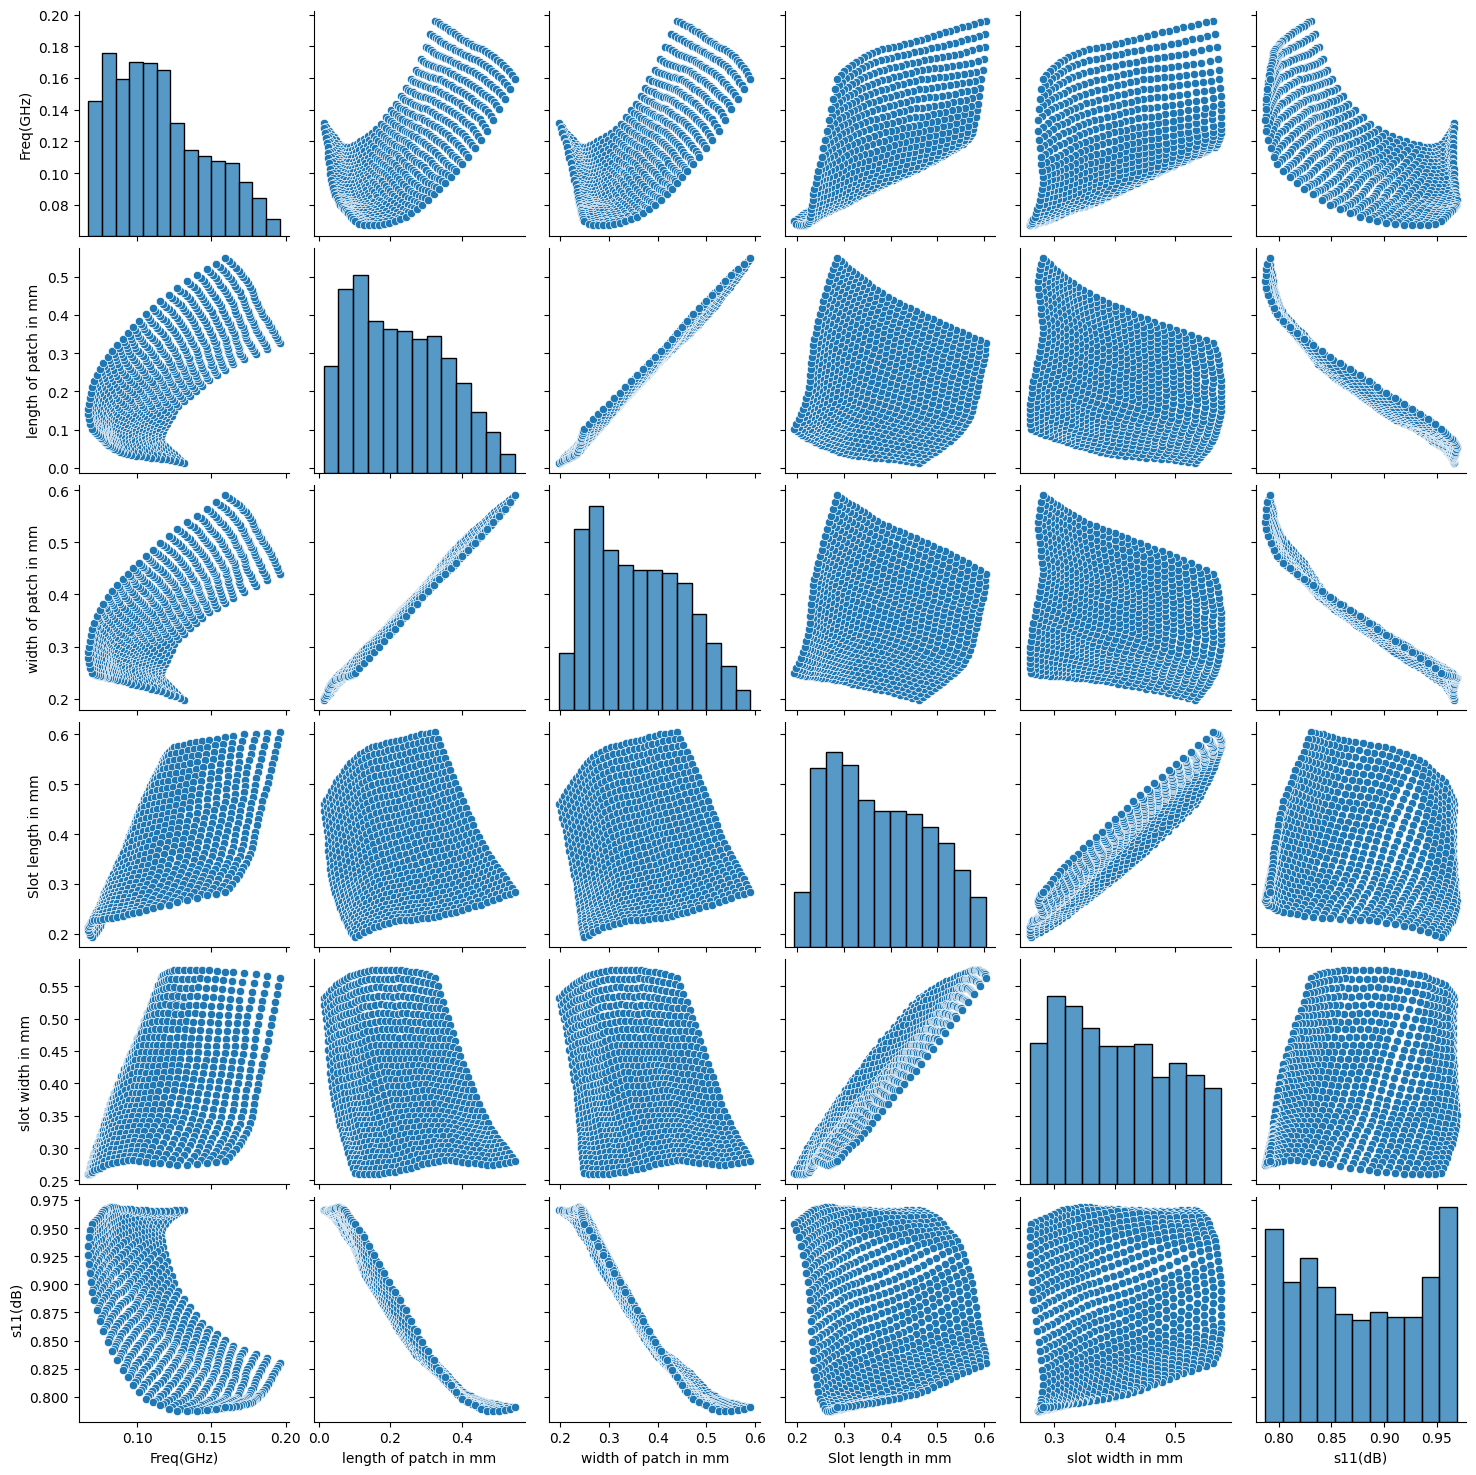

In [66]:
#SYNDATA VISUALISATION
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot
sns.pairplot(synth_data)
plt.show()

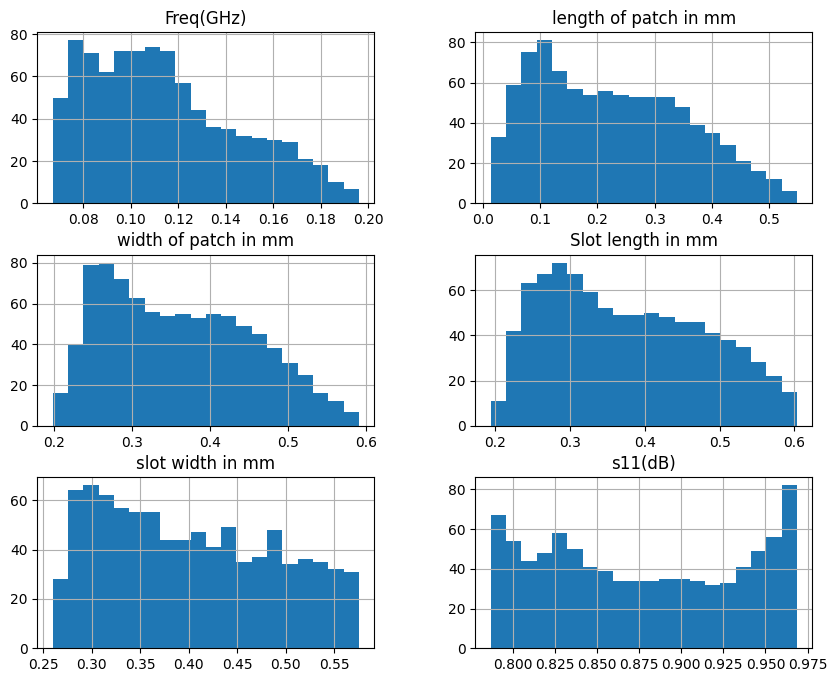

In [67]:
#HISTOGRAMS
# Plot histograms for all features
synth_data.hist(bins=20, figsize=(10, 8))
plt.show()

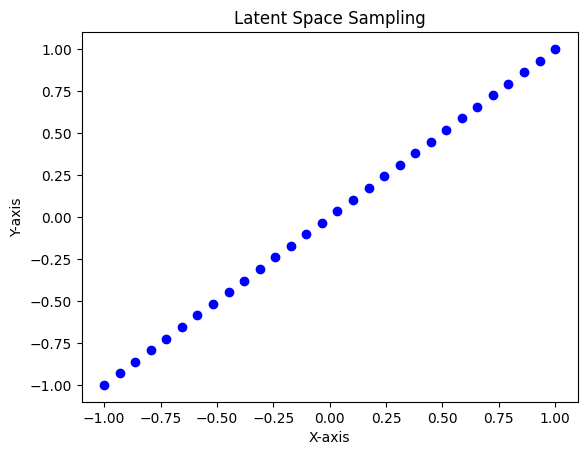

In [68]:
#SCATTERING ON 2D LATENT SPACE
# Plot the latent space grid
plt.scatter(grid_x, grid_y, c='blue', marker='o')
plt.title("Latent Space Sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [70]:
feature_name = 'Freq(GHz)'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

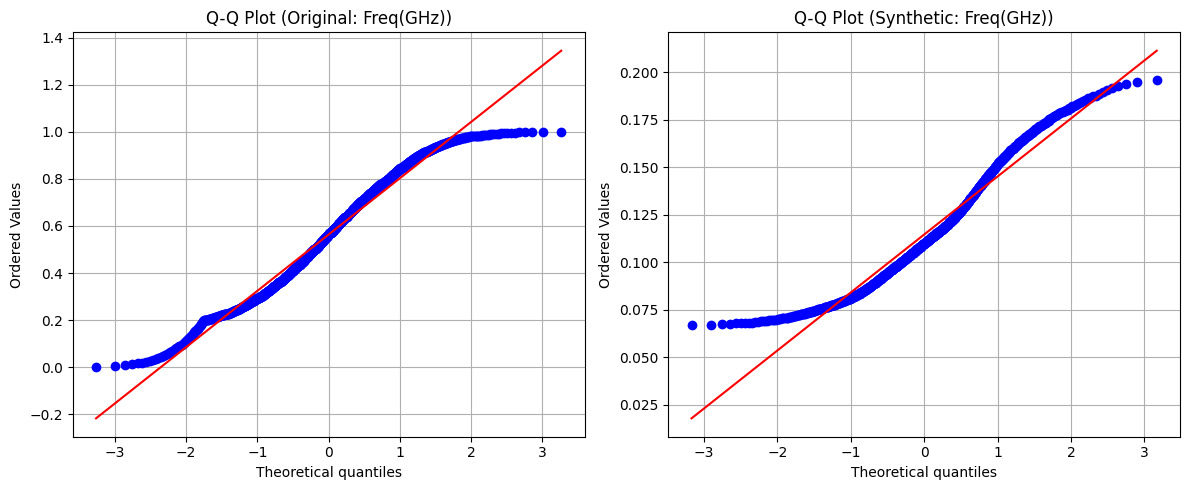

In [71]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [72]:
feature_name = 'length of patch in mm'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

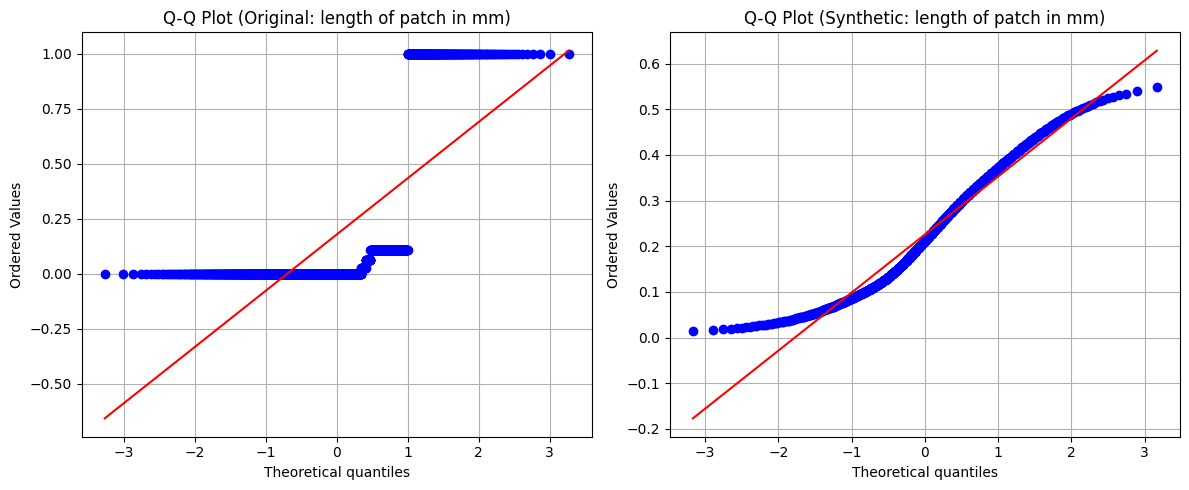

In [73]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [74]:
feature_name = 'width of patch in mm'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

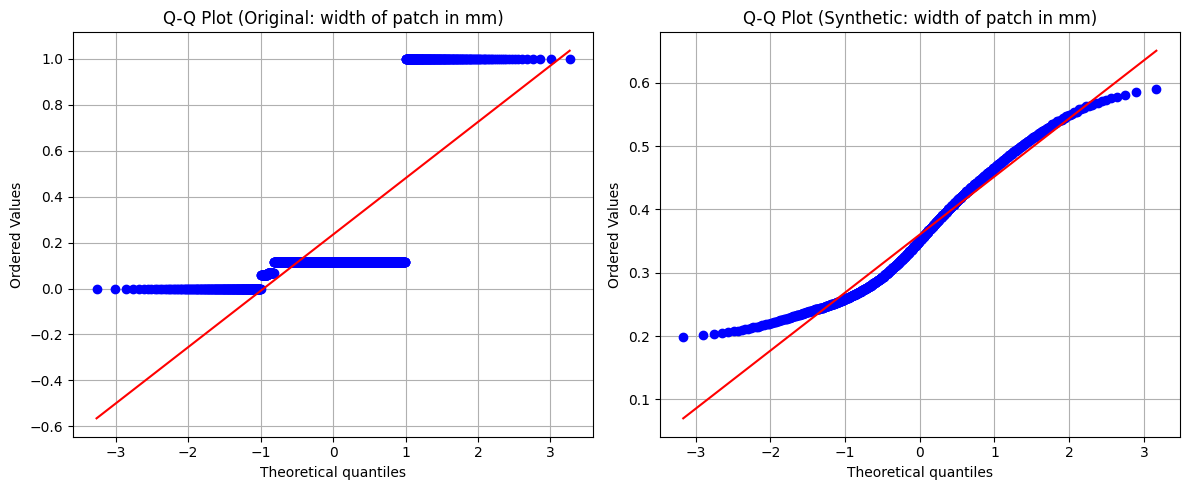

In [75]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [76]:
feature_name = 'Slot length in mm'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

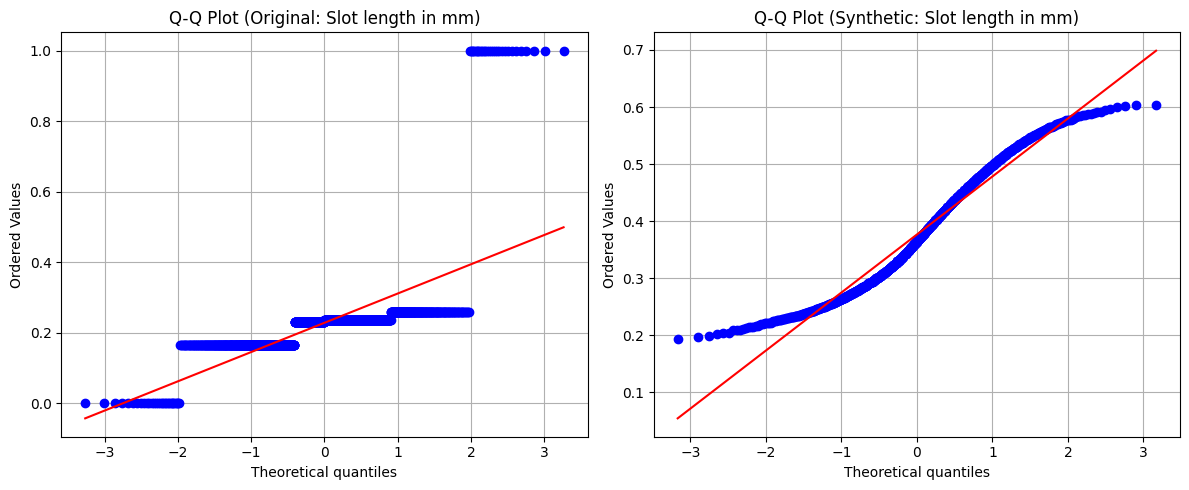

In [77]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [78]:
feature_name = 'slot width in mm'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

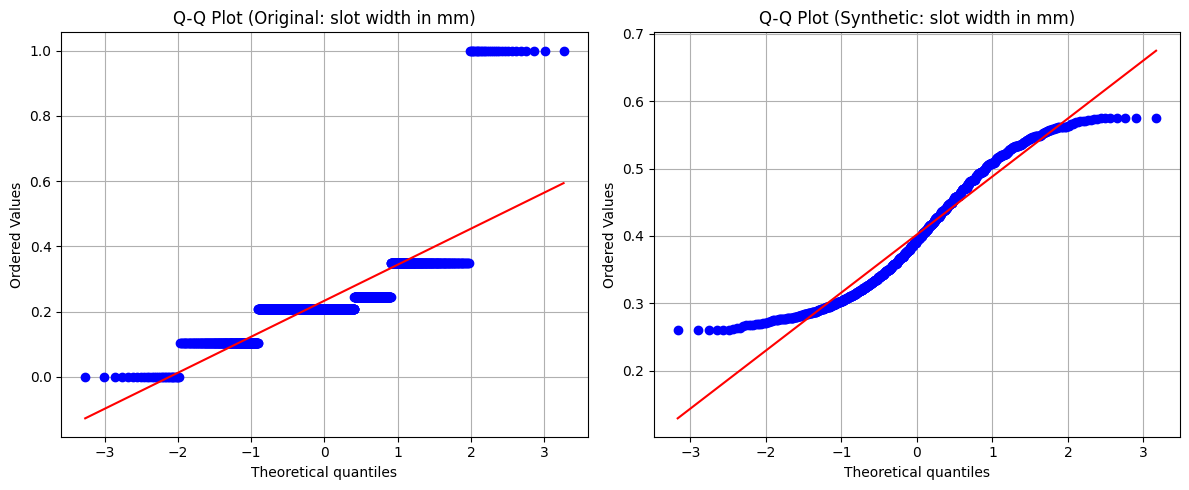

In [79]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [80]:
feature_name = 's11(dB)'  # Replace with your feature name
original_feature = norm_df[feature_name]
synthetic_feature = synth_data[feature_name]

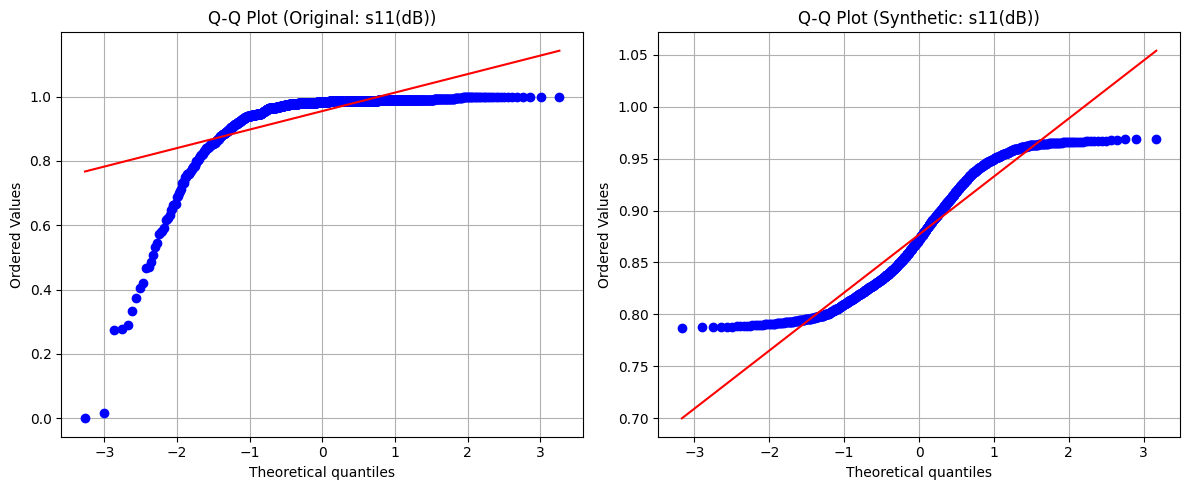

In [81]:
# Create a figure with two subplots (original vs. synthetic)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for original data vs. normal distribution
stats.probplot(original_feature, dist="norm", plot=ax1)
ax1.set_title(f'Q-Q Plot (Original: {feature_name})')
ax1.grid(True)

# Q-Q plot for synthetic data vs. normal distribution
stats.probplot(synthetic_feature, dist="norm", plot=ax2)
ax2.set_title(f'Q-Q Plot (Synthetic: {feature_name})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [84]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency, wasserstein_distance
from scipy.special import kl_div

def statistical_similarity(original_data, synthetic_data):
    results = {}

    for col in original_data.columns:
        # KS Test (for continuous data)
        ks_stat, ks_p = ks_2samp(original_data[col], synthetic_data[col])

        # Wasserstein Distance
        w_dist = wasserstein_distance(original_data[col], synthetic_data[col])

        # KL Divergence (avoid zeros for stability)
        hist_orig, _ = np.histogram(original_data[col], bins=50, density=True)
        hist_synth, _ = np.histogram(synthetic_data[col], bins=50, density=True)
        kl_divergence = np.sum(kl_div(hist_orig + 1e-10, hist_synth + 1e-10))

        results[col] = {
            "Wasserstein_Distance": w_dist,
            "KL_Divergence": kl_divergence
        }

    return pd.DataFrame(results).T

# Example usage
similarity_results = statistical_similarity(norm_df, synth_data)
print("Statistical Similarity Results:")
print(similarity_results)

Statistical Similarity Results:
                       Wasserstein_Distance  KL_Divergence
Freq(GHz)                          0.449828     253.672224
length of patch in mm              0.227665     195.138641
width of patch in mm               0.280974     186.605428
Slot length in mm                  0.167801     146.065019
slot width in mm                   0.188918     164.938254
s11(dB)                            0.092915     236.131381


In [85]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def privacy_metrics(original_data, synthetic_data):
    # Ensure input is NumPy arrays
    original_data = np.array(original_data)
    synthetic_data = np.array(synthetic_data)

    # Distance to Closest Record (DCR)
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_data)
    distances, _ = nbrs.kneighbors(synthetic_data)
    avg_dcr = np.mean(distances)

    # Membership Inference Attack Risk (Simplified)
    mia_risk = 1 / (1 + avg_dcr)  # Lower distance → Higher risk

    return {
        "Avg_Distance_to_Closest_Record": avg_dcr,
        "MIA_Risk_Score": mia_risk
    }

# Example usage
privacy_results = privacy_metrics(norm_df.values, synth_data.values)
print("Privacy Metrics:", privacy_results)

Privacy Metrics: {'Avg_Distance_to_Closest_Record': np.float64(0.45796501819067403), 'MIA_Risk_Score': np.float64(0.6858875127477297)}
